In [3]:
from data_tools.api import *
from utilscht.Data import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from volat_calcu import *
import pymysql
from joblib import Parallel,delayed
%config InlineBackend.figure_format ='retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from reader import *


DB_INFO = dict(host='192.168.1.234',
               user='winduser',
               password='1qaz@WSX',
               db='wind')

conn = pymysql.connect(**DB_INFO, charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)

In [4]:
def apply_parallel(df_grouped, func, n_jobs=16, backend='loky', as_index=True, ratio=0.1):
    """
    This is for parallel between grouped generated by pd.DataFrame.groupby
    :param df_grouped:
    :param func:
    :param n_jobs:
    :param backend:
    :param kwargs:
    :return:
    """

    names = []
    groups = []
    for name, group in df_grouped:
        names.append(name)
        groups.append(group)

    results = Parallel(n_jobs=n_jobs, verbose=5, backend=backend, batch_size='auto') \
        (delayed(func)(group) for group in groups)

    return pd.concat(results, keys=names if as_index else None)

In [5]:
from data_tools.api import trade_days

trade_dates_all = trade_days.copy()
def get_prev_n_trade_date(trade_date, n):
    trade_date=str(trade_date)[0:10].replace('-','')
    pos = np.searchsorted(trade_dates_all, trade_date)
    try:
        assert pos >= n
        return str(trade_dates_all[pos - n])
    except AssertionError:
        return "20200101"

def get_next_n_trade_date(trade_date, n=1):
    trade_date=str(trade_date)[0:10].replace('-','')
    pos = np.searchsorted(trade_dates_all, trade_date, side='right')
    try:
        assert pos + n - 1 < len(trade_dates_all)
        return str(trade_dates_all[pos + n - 1])
    except AssertionError:
        return "20201231"

In [6]:

trade_dates=get_trade_dates('20180101',"20200331")
trade_dates=[str(i) for i in trade_dates]

df_cross_grid_count=pd.DataFrame()
for date in trade_dates:
    stock_pool=pd.read_csv(r"/share/xfzhang/to_colleague/to_yzhao/task2/{}/{}/task2_{}.csv".format(date[0:4],date[4:6],date[0:8]))["sid"]
    cross_grid=pd.read_excel(r"/home/ywang/proj_cross_grid/result/cross_count_b240/crosscount_summary_{}.xlsx".format(date))
    cross_grid=cross_grid.set_index("sid").loc[stock_pool].reset_index()[['sid','5d_count','10d_count']]
    cross_grid["date"]=date
    
    df_cross_grid_count=pd.concat([df_cross_grid_count,cross_grid])

df_cross_grid_count=df_cross_grid_count[(df_cross_grid_count["5d_count"]>=20) & (df_cross_grid_count["10d_count"]>=40)]
df_cross_grid_count=df_cross_grid_count.set_index("date").reset_index().sort_values(by=["date","sid"])

/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [268]:
def get_change_to_60d_high_v2(df):
    sid = df["sid"].iloc[0]
    date = df["date"].iloc[0]
    
    df_stk_price = get_stk_bar(sid,start=get_prev_n_trade_date(date,60),\
                               end = date,fields =["adj_high","adj_close","adj_factor"])
    price_60d_high = np.nanmax(df_stk_price["adj_high"])
    adj_close_yd = df_stk_price["adj_close"].iloc[-1]

    change_to_60d_high = (price_60d_high - adj_close_yd)/price_60d_high
    df["change_to_60d_high"] = - change_to_60d_high
    
    return df

In [269]:
groups = df_cross_grid_count.groupby(["sid","date"])
df_change_to_60d_high = apply_parallel(groups,get_change_to_60d_high_v2,as_index=False)
df_change_to_60d_high

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    5.2s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    9.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   14.4s
[Parallel(n_jobs=16)]: Done 616 tasks      | elapsed:   20.3s
[Parallel(n_jobs=16)]: Done 850 tasks      | elapsed:   27.1s
[Parallel(n_jobs=16)]: Done 1120 tasks      | elapsed:   34.6s
[Parallel(n_jobs=16)]: Done 1426 tasks      | elapsed:   41.5s
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:   49.3s
[Parallel(n_jobs=16)]: Done 2146 tasks      | elapsed:   57.7s
[Parallel(n_jobs=16)]: Done 2560 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 3010 tasks      | elapsed:  1.3min
[Parallel(n_jobs=16)]: Done 3496 tasks      | elapsed:  1.5min
[Parallel(n_jobs=16)]: Done 4018 tasks      | elapsed:  1.7min
[Parallel(n_jobs=16)]: Done 4576 tasks      | e

,date,sid,5d_count,10d_count,change_to_60d_high
0,20180102,000001.SZ,26.0,45.0,-0.101052
57,20180103,000001.SZ,26.0,45.0,-0.125328
122,20180104,000001.SZ,26.0,48.0,-0.130581
183,20180105,000001.SZ,21.0,44.0,-0.127297
239,20180108,000001.SZ,20.0,45.0,-0.149610
...,...,...,...,...,...
5719,20180403,603993.SH,20.0,71.0,-0.167246
6462,20180418,603993.SH,22.0,40.0,-0.206133
6630,20180420,603993.SH,24.0,41.0,-0.217199
6719,20180423,603993.SH,27.0,41.0,-0.219412


# 高位偏离前25%回测

In [294]:
trade_dates = get_trade_dates("20180301","20200331")

def get_daily_ret(df_daily):
    df_daily = df_daily.sort_values("change_to_60d_high")
    #取前25%
    stk_ls = df_daily["sid"].iloc[:int(0.25*len(df_daily))]
    
    #分为10组，每组取中间两个
    """
    if len(df_daily) <=20:
        stk_ls = df_daily["sid"].values
    elif len(df_daily)<=40:
        df_daily["change_to_60d_high"] = df_daily["change_to_60d_high"].\
                                          apply(lambda x:np.random.randint(0,10)/100 if x == 0.0 else x)
        df_daily["group"] = pd.qcut(df_daily["change_to_60d_high"],10,
                                    labels = np.arange(10),duplicates="raise") 
        get_stk = lambda x:x["sid"].iloc[:2] if len(x)<=3 else x["sid"].iloc[1:3]
        stk_ls = list(df_daily.groupby("group").apply(get_stk))
    else:
        df_daily["change_to_60d_high"] = df_daily["change_to_60d_high"].\
                                          apply(lambda x:np.random.randint(0,10)/100 if x == 0.0 else x)
        df_daily["group"] = pd.qcut(df_daily["change_to_60d_high"],10,
                                    labels = np.arange(10),duplicates="raise")
        get_stk = lambda x:x["sid"].iloc[int(len(x)/2)-1:int(len(x)/2)+1] if len(x)%2==0 \
                            else x["sid"].iloc[int(len(x)/2)-1:int(len(x)/2)+1]
        stk_ls = list(df_daily.groupby("group").apply(get_stk))
    """ 

    
    date = df_daily["date"].iloc[0]
    next_date= get_next_trade_date(date)
    
    today_price=query_table("DailyBar",start_date=date,end_date=date,fields=["tradable","adj_close"])
    today_price=today_price[today_price["tradable"]==1]
    
    next_date_price=query_table("DailyBar",start_date=next_date,end_date=next_date,fields=["tradable","adj_close"])
    next_date_price=next_date_price[next_date_price["tradable"]==1]
        
    merged_price=pd.merge(today_price,next_date_price,on="sid")
    merged_price["change_rate"]=merged_price["adj_close_y"]/merged_price["adj_close_x"]-1
    
    merged_price = merged_price.set_index("sid").loc[stk_ls].reset_index()
    
    
    return  pd.DataFrame(data = [[np.nanmean(merged_price["change_rate"]),len(stk_ls)]],
                        columns = ["ret","stk_num"],index = [date])


groups = df_change_to_60d_high.groupby("date")
df = apply_parallel(groups,get_daily_ret,as_index=False)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:   11.0s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:   19.7s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   30.9s
[Parallel(n_jobs=16)]: Done 545 out of 545 | elapsed:   39.3s finished


In [290]:
df_change_to_60d_high.sort_values(["date"])

,date,sid,5d_count,10d_count,change_to_60d_high
0,20180102,000001.SZ,26.0,45.0,-0.101052
39,20180102,600196.SH,32.0,54.0,-0.080700
38,20180102,600188.SH,34.0,64.0,-0.000000
5,20180102,000786.SZ,34.0,67.0,-0.084802
37,20180102,600176.SH,38.0,85.0,-0.000000
...,...,...,...,...,...
39630,20200331,000596.SZ,41.0,93.0,-0.277483
39656,20200331,002236.SZ,28.0,65.0,-0.290164
39649,20200331,002065.SZ,53.0,124.0,-0.266734
39666,20200331,002475.SZ,47.0,108.0,-0.260899


In [ ]:
ret_arr = df_ret["ret"].values
df_ret["cum_ret"] = np.cumprod(1+ret_arr)
df_ret.index = pd.to_datetime(df_ret.index)
df_ret[["ret"]].plot()
df_ret[["cum_ret"]].plot()

In [91]:
conn = pymysql.connect(**DB_INFO, charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
sql="select TRADE_DT,S_DQ_CLOSE,S_DQ_HIGH,S_DQ_LOW FROM AINDEXEODPRICES WHERE S_INFO_WINDCODE ='000300.SH'"
index_hq=pd.read_sql(sql,conn)
index_hq.sort_values("TRADE_DT",inplace=True)
index_hq = index_hq.set_index("TRADE_DT").loc["20180301":"20200331"]
index_hq.index = pd.to_datetime(index_hq.index)

In [ ]:
df_ret["hs300_ret"] = index_hq["hs300_ret"]
df_ret["hedge_ret"] = df_ret["ret"] - df_ret["hs300_ret"]
df_ret["cum_hedge_ret"] = np.cumprod(1+df_ret["hedge_ret"])
df_ret = df_ret.dropna()

df_ret["cum_hedge_ret"].plot()
plt.show()
df_ret["hedge_ret"].plot()
plt.show()

In [ ]:
df_ret["cum_hedge_ret"] = 1+np.cumsum(df_ret["hedge_ret"])
df_ret["cum_hedge_ret"].plot()

In [ ]:
def get_max_drawdown(arr):
    max_drawdown=0
    for i in range(len(arr)):
        cum_ret=np.cumprod(1+arr[i:])
        if (1 - np.min(cum_ret)) > max_drawdown:
            max_drawdown = 1 - np.min(cum_ret)
    return max_drawdown

def get_indicator_df(sid,df):    
    indicator_df=pd.DataFrame(index=pd.MultiIndex.from_product([[sid],["strategy"]]),\
                          columns=["tot_return","yearly_ret","daily_volat","yearly_volat","sharpe","yearly_sharpe","max_drawdown"])
    indicator_df.loc[(sid,"strategy"),"tot_return"] = df["cum_hedge_ret"].iloc[-1]-1
    indicator_df.loc[(sid,"strategy"),"yearly_ret"] = np.power(df["cum_hedge_ret"].iloc[-1],252/len(df))-1
    indicator_df.loc[(sid,"strategy"),"daily_volat"] = np.nanstd(df["hedge_ret"])
    indicator_df.loc[(sid,"strategy"),"yearly_volat"] = np.nanstd(df["hedge_ret"])*np.sqrt(252)
    indicator_df.loc[(sid,"strategy"),"sharpe"] = np.nanmean(df["hedge_ret"]) / np.nanstd(df["hedge_ret"])
    indicator_df.loc[(sid,"strategy"),"yearly_sharpe"] = indicator_df.loc[(sid,"strategy"),"yearly_ret"] / indicator_df.loc[(sid,"strategy"),"yearly_volat"]
    indicator_df.loc[(sid,"strategy"),"max_drawdown"] =  get_max_drawdown(df["hedge_ret"].dropna().values) 
    return indicator_df

In [ ]:
get_indicator_df("1:1 hs300对冲",df_ret)

In [ ]:
def get_daily_stkpool(df_daily):
    df_daily = df_daily.sort_values("change_to_60d_high")
    #取前25%
    stk_ls = df_daily["sid"].iloc[:int(0.25*len(df_daily))]
    return stk_ls
df_stkpool = df_change_to_60d_high.groupby("date").apply(get_daily_stkpool).to_frame("sid")
df_stkpool

In [ ]:
turnover_ls = []
for date in get_trade_dates("20180301","20200330"):
    stk_pool_td = df_stkpool["sid"].loc[date]
    stk_pool_yd = df_stkpool["sid"].loc[get_previous_trade_date(date)]
    
    common_stk = set(stk_pool_td)& set(stk_pool_yd)
    stk_sell_ratio = (len(stk_pool_yd) - len(common_stk) ) /len(stk_pool_yd)
    stk_buy_ratio = (len(stk_pool_td) - len(common_stk) ) / len(stk_pool_td)
    
    weight_change_ratio = len(common_stk)*abs(1/len(stk_pool_td)-1/len(stk_pool_yd))
    
    turnover_ls.append(stk_buy_ratio+stk_sell_ratio+weight_change_ratio)
sum(turnover_ls)/len(turnover_ls)

1. 把底池换成白马5日波动大于20 10日大于40那个 然后 5日跑输300百分10且盘中跌幅达到-百分4的收盘买入百分5 

2. 10天内最低到最高跑赢300百分20出场 静默这个票10个交易日

3. 5日跑赢300百分10且处于60日最高位出场 静默至低于60日高位百分15

4. 单个股票最多百分5权重 底池少于20只就是减仓

In [337]:
trade_dates = get_trade_dates("20180301","20200331")

def get_daily_ret(df_daily):
    date = df_daily["date"].iloc[0]
    df_daily = df_daily.sort_values("change_to_60d_high")
    df_daily = df_daily.iloc[:int(0.25*len(df_daily))]
    next_date= get_next_trade_date(date)
    pre_date = get_previous_trade_date(date)
    
    stk_pool = df_daily["sid"].values
    
    df_to_hs300 = pd.read_csv(r"/share/xfzhang/to_colleague/to_yzhao/task2/{}/{}/task2_{}.csv".format(date[0:4],date[4:6],date))
    df_to_hs300 = df_to_hs300.set_index("sid").loc[stk_pool].reset_index()
    stk_pool_1 = df_to_hs300["sid"][df_to_hs300["ret_5d_hs300"] < -0.1].values
    
    df_yd_td = pd.merge(query_table("DailyBar",start_date=date,end_date=date,fields=["adj_low"]),
             query_table("DailyBar",start_date=pre_date,end_date=pre_date,fields=["adj_close"]),
             on = "sid")
    df_yd_td["max_decre"] = df_yd_td["adj_low"]/df_yd_td["adj_close"] - 1
    stk_pool_2 = df_yd_td['sid'][df_yd_td["max_decre"] <-0.04].values
    
    stk_ls = list(set(stk_pool_1) & set(stk_pool_2))
    
    today_price=query_table("DailyBar",start_date=date,end_date=date,fields=["tradable","adj_close"])
    today_price=today_price[today_price["tradable"]==1]
    
    next_date_price=query_table("DailyBar",start_date=next_date,end_date=next_date,fields=["tradable","adj_close"])
    next_date_price=next_date_price[next_date_price["tradable"]==1]
        
    merged_price=pd.merge(today_price,next_date_price,on="sid")
    merged_price["change_rate"]=merged_price["adj_close_y"]/merged_price["adj_close_x"]-1
    
    merged_price = merged_price.set_index("sid").loc[stk_ls].reset_index()
    
    
    return  pd.DataFrame(data = [[len(stk_ls),stk_ls]],
                        columns = ["stk_num","stk_ls"],index = [date])

In [ ]:
get_daily_ret(df_change_to_60d_high.groupby("date").get_group("20200309"))

In [338]:
groups = df_change_to_60d_high.groupby("date")
df_stk_ls = apply_parallel(groups,get_daily_ret,as_index=False)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    9.6s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:   24.7s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:   47.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.2min
[Parallel(n_jobs=16)]: Done 545 out of 545 | elapsed:  1.6min finished


In [339]:
df_ret = pd.DataFrame(index=trade_dates)

In [352]:
trade_dates = get_trade_dates("20180301","20200331")

df_ret["ret_1"] = np.nan
df_ret["ret_1_comp"] = np.nan

df_stk_ls["stk_pool_1"] = np.nan
df_stk_ls["stk_pool_1_5%"] = np.nan

for date in trade_dates:
    print(date,end="\n")
    next_date = get_next_trade_date(date)
    df_daily = df_change_to_60d_high[df_change_to_60d_high["date"] == date]
    df_daily = df_daily.sort_values("change_to_60d_high")
    df_daily = df_daily.iloc[:int(0.25*len(df_daily))]
    stk_ls_1 = list(df_daily["sid"].values)
    stk_ls_2 = df_stk_ls["stk_ls"].loc[date]
    
    weight  = [(1-0.05*len(stk_ls_2))/len(set(stk_ls_1)- set(stk_ls_2))
               if stk not in stk_ls_2 and len(stk_ls_1)>=20 
               else 0.05 
               for stk in stk_ls_1]
    if abs(sum(weight) -1) >0.01:
        print("Weight<1 for {}:{}".format(date,sum(weight)))
    
    today_price=query_table("DailyBar",start_date=date,end_date=date,fields=["tradable","adj_close"])
    today_price=today_price[today_price["tradable"]==1]
    
    next_date_price=query_table("DailyBar",start_date=next_date,end_date=next_date,fields=["tradable","adj_close"])
    next_date_price=next_date_price[next_date_price["tradable"]==1]
        
    merged_price=pd.merge(today_price,next_date_price,on="sid")
    merged_price["change_rate"]=merged_price["adj_close_y"]/merged_price["adj_close_x"]-1
    
    merged_price = merged_price.set_index("sid").loc[stk_ls_1].reset_index()
    df_ret.loc[date,"ret_1"] = np.sum(merged_price["change_rate"]*np.array(weight))
    df_ret.loc[date,"ret_1_comp"] = np.mean(merged_price["change_rate"])
    
    df_stk_ls["stk_pool_1"].loc[date] = stk_ls_1
    df_stk_ls["stk_pool_1_5%"].loc[date] = stk_ls_2

20180301


/home/ywang/env/dev/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20180302
20180305
20180306
20180307
Weight<1 for 20180307:0.8500000000000002
20180308
Weight<1 for 20180308:0.8500000000000002
20180309
Weight<1 for 20180309:0.7500000000000001
20180312
Weight<1 for 20180312:0.7500000000000001
20180313
Weight<1 for 20180313:0.5499999999999999
20180314
Weight<1 for 20180314:0.49999999999999994
20180315
Weight<1 for 20180315:0.49999999999999994
20180316
Weight<1 for 20180316:0.39999999999999997
20180319
Weight<1 for 20180319:0.44999999999999996
20180320
Weight<1 for 20180320:0.6
20180321
Weight<1 for 20180321:0.7000000000000001
20180322
Weight<1 for 20180322:0.7000000000000001
20180323
20180326
20180327
20180328
20180329
20180330
20180402
20180403
20180404
20180409
20180410
20180411
20180412
Weight<1 for 20180412:0.9000000000000002
20180413
Weight<1 for 20180413:0.8500000000000002
20180416
Weight<1 for 20180416:0.7500000000000001
20180417
Weight<1 for 20180417:0.9000000000000002
20180418
20180419
20180420
20180423
20180424
20180425
Weight<1 for 20180425:

/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


20181008
Weight<1 for 20181008:0.8000000000000002
20181009
Weight<1 for 20181009:0.8500000000000002
20181010
Weight<1 for 20181010:0.8500000000000002
20181011
20181012
20181015
20181016
20181017
20181018
20181019
20181022
20181023
20181024
20181025
20181026
20181029
20181030
20181031
20181101
20181102
20181105
20181106
20181107
20181108
20181109
Weight<1 for 20181109:0.8500000000000002
20181112
Weight<1 for 20181112:0.7000000000000001
20181113
Weight<1 for 20181113:0.8500000000000002
20181114
Weight<1 for 20181114:0.8000000000000002
20181115
Weight<1 for 20181115:0.7000000000000001
20181116
Weight<1 for 20181116:0.7000000000000001
20181119
Weight<1 for 20181119:0.7000000000000001
20181120
Weight<1 for 20181120:0.7000000000000001
20181121
Weight<1 for 20181121:0.7500000000000001
20181122
Weight<1 for 20181122:0.8000000000000002
20181123
Weight<1 for 20181123:0.7500000000000001
20181126
Weight<1 for 20181126:0.7000000000000001
20181127
Weight<1 for 20181127:0.65
20181128
Weight<1 for 201

In [368]:
df_stk_ls.head()

,stk_num,stk_ls,stk_pool_1,stk_pool_1_5%,position_pool_1,stk_pool_2,stk_pool_2_5%,position_pool_2,stk_num_2,stk_num_1
20180301,1,[002508.SZ],"[300136.SZ, 600383.SH, 002673.SZ, 002508.SZ, 0...",[002508.SZ],1.00,"[600383.SH, 002673.SZ, 002508.SZ, 002773.SZ, 6...",[002508.SZ],0.95,19,24
20180302,0,[],"[300136.SZ, 600383.SH, 600760.SH, 002773.SZ, 6...",[],1.00,"[600383.SH, 002773.SZ, 600188.SH, 002508.SZ, 6...",[],0.90,18,24
20180305,1,[600188.SH],"[300136.SZ, 600383.SH, 600188.SH, 002508.SZ, 0...",[600188.SH],1.00,"[600383.SH, 600188.SH, 002508.SZ, 002146.SZ, 0...",[600188.SH],0.85,17,22
20180306,0,[],"[300136.SZ, 002508.SZ, 600383.SH, 002714.SZ, 6...",[],1.00,"[002508.SZ, 600383.SH, 002714.SZ, 600188.SH, 0...",[],0.85,17,21
20180307,0,[],"[300136.SZ, 600383.SH, 600188.SH, 002508.SZ, 6...",[],0.85,"[600383.SH, 600188.SH, 002508.SZ, 600516.SH, 0...",[],0.65,13,17


In [366]:
df_stk_ls["position_pool_1"] = df_stk_ls["stk_pool_1"].apply(lambda x:0.05*len(x) if len(x)<20 else 1)
df_stk_ls["stk_num_1"] = df_stk_ls["stk_pool_1"].apply(lambda x:len(x))

/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


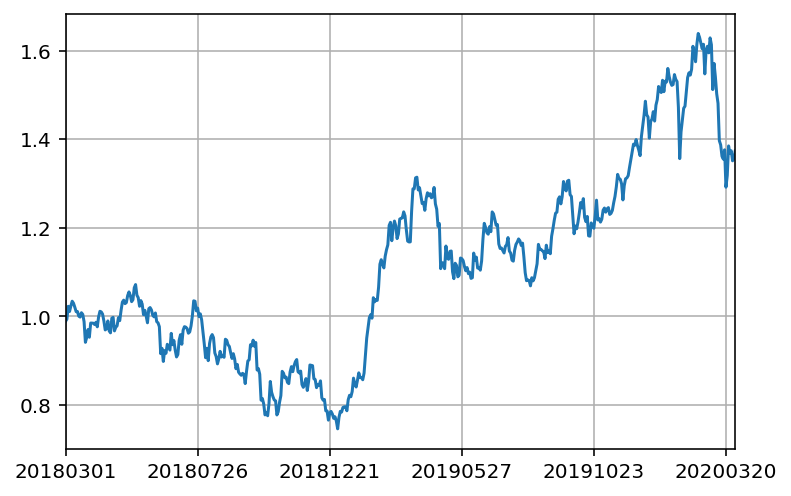

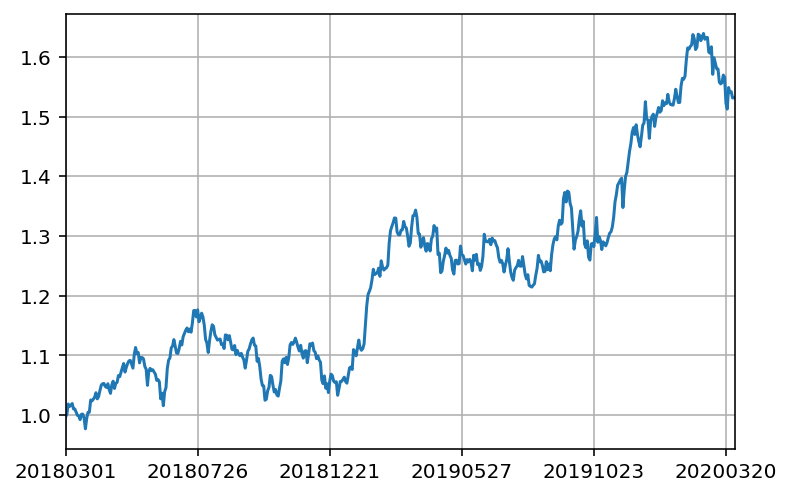

In [359]:
np.cumprod(1+df_ret["ret_1_comp"]).plot()
plt.grid()
plt.show()
index_hq["hs300_ret"] =(index_hq["S_DQ_CLOSE"].shift(-1) - index_hq["S_DQ_CLOSE"])/index_hq["S_DQ_CLOSE"]
np.cumprod(1+df_ret["ret_1_comp"]-index_hq["hs300_ret"]).plot()
plt.grid()
plt.show()

In [360]:
def get_stk_to_hs300(sid,date,period,kind):
    date_ndp = get_prev_n_trade_date(date,period)
    try:
        stk_bar = get_stk_bar(sid,start=date_ndp,
                              end=date,fields=["adj_close","adj_low","adj_high"])
    except KeyError:
        print(("Data Loss for {} in {}".format(sid,date)))
        return 0
    if len(stk_bar) < period/2:
        print(("Data Incomplete for {} in {}".format(sid,date)))
        return 0
    hs300_bar = index_hq.loc[date_ndp:date]
    if kind == "close":
        stk_change_rate = stk_bar["adj_close"].iloc[-1] / stk_bar["adj_close"].iloc[0]  -  1
        index_change_rate = hs300_bar["S_DQ_CLOSE"].iloc[-1] /hs300_bar["S_DQ_CLOSE"].iloc[0] - 1
    elif kind == "low_high":
        argmin = np.nanargmin(stk_bar["adj_low"])
        stk_change_rate = np.nanmax(stk_bar["adj_high"].iloc[argmin:]) / np.nanmin(stk_bar["adj_low"])  -  1
        argmin = np.nanargmin(hs300_bar["S_DQ_LOW"])
        index_change_rate = np.nanmax(hs300_bar["S_DQ_HIGH"].iloc[argmin:]) /np.nanmin(hs300_bar["S_DQ_LOW"]) - 1
    
    
    return stk_change_rate - index_change_rate

In [361]:
def get_stk_to_60d_high(sid,date):   
    try:
        df_stk_price = get_stk_bar(sid,start=get_prev_n_trade_date(date,60),\
                                   end = date,fields =["adj_high"])
    except KeyError:
        print(("Data Loss for {} in {}".format(sid,date)))
        return 0
    
    if len(df_stk_price) < 30:
        print(("Data Incomplete for {} in {}".format(sid,date)))
        return 0
        
    price_60d_high =    np.nanmax(df_stk_price["adj_high"])
    adj_close_td = df_stk_price["adj_high"].iloc[-1]

    change_to_60d_high = (price_60d_high - adj_close_td)/price_60d_high
    return -change_to_60d_high

In [362]:
trade_dates = get_trade_dates("20180301","20200331")
stk_silent_dict = {}
stk_silent_ls = []

df_ret["ret_2"] = np.nan
df_ret["ret_2_comp"] = np.nan

df_stk_ls["stk_pool_2"] = np.nan
df_stk_ls["stk_pool_2_5%"] = np.nan

for date in trade_dates:
    print(date,end=" ")
    next_date = get_next_trade_date(date)
    df_daily = df_change_to_60d_high[df_change_to_60d_high["date"] == date]
    df_daily = df_daily.sort_values("change_to_60d_high")
    df_daily = df_daily.iloc[:int(0.25*len(df_daily))]
    stk_ls_1 = list(df_daily["sid"].values)
    stk_ls_2 = list(df_stk_ls["stk_ls"].loc[date])
    
    
    #静默一部分股票：10天内最低到最高跑赢300百分20出场 静默这个票10个交易日
    for stk in stk_ls_1:
        if get_stk_to_hs300(stk,date,period=10,kind="low_high")>0.2:
            stk_silent_dict[stk] = 0
    for stk in list(stk_silent_dict.keys()):
        stk_silent_dict[stk] = stk_silent_dict[stk] + 1
        if stk_silent_dict[stk] >10:
            del stk_silent_dict[stk]
    for stk in stk_ls_1:
        if stk in stk_silent_dict.keys():
            stk_ls_1.remove(stk)
            
    #静默一部分股票：5日跑赢300百分10且处于60日最高位出场 静默至低于60日高位百分15
    for stk in stk_ls_1:
        if get_stk_to_hs300(stk,date,period=5,kind="close")>0.1 and get_stk_to_60d_high(stk,date) == 0 :
            stk_silent_ls.append(stk)
    stk_silent_ls = list({}.fromkeys(stk_silent_ls).keys())
    for stk in stk_silent_ls:
        if get_stk_to_60d_high(stk,date) <-0.15:
            stk_silent_ls.remove(stk)
    for stk in stk_ls_1:
        if stk in stk_silent_ls:
            stk_ls_1.remove(stk)
    
    for stk in stk_ls_2:
        if stk not in stk_ls_1:
            stk_ls_2.remove(stk)

    weight  = [(1-0.05*len(stk_ls_2))/len(set(stk_ls_1)- set(stk_ls_2))
               if stk not in stk_ls_2 and len(stk_ls_1)>=20 
               else 0.05 
               for stk in stk_ls_1]
    
    today_price=query_table("DailyBar",start_date=date,end_date=date,fields=["tradable","adj_close"])
    today_price=today_price[today_price["tradable"]==1]
    
    next_date_price=query_table("DailyBar",start_date=next_date,end_date=next_date,fields=["tradable","adj_close"])
    next_date_price=next_date_price[next_date_price["tradable"]==1]
        
    merged_price=pd.merge(today_price,next_date_price,on="sid")
    merged_price["change_rate"]=merged_price["adj_close_y"]/merged_price["adj_close_x"]-1
    
    merged_price = merged_price.set_index("sid").loc[stk_ls_1].reset_index()
    df_ret.loc[date,"ret_2"] = np.sum(merged_price["change_rate"]*np.array(weight))
    df_ret.loc[date,"ret_2_comp"] = np.mean(merged_price["change_rate"])
    
    df_stk_ls["stk_pool_2"].loc[date] = stk_ls_1
    df_stk_ls["stk_pool_2_5%"].loc[date] = stk_ls_2

/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


20180301 

/home/ywang/env/dev/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


20180302 20180305 20180306 20180307 20180308 20180309 20180312 20180313 20180314 20180315 20180316 20180319 20180320 20180321 20180322 20180323 20180326 20180327 20180328 20180329 20180330 20180402 20180403 20180404 20180409 20180410 20180411 20180412 20180413 20180416 20180417 20180418 20180419 20180420 20180423 20180424 20180425 20180426 20180427 20180502 20180503 20180504 20180507 20180508 20180509 20180510 20180511 20180514 20180515 20180516 20180517 20180518 20180521 20180522 20180523 20180524 20180525 20180528 20180529 20180530 20180531 20180601 20180604 20180605 20180606 20180607 20180608 20180611 20180612 20180613 20180614 20180615 20180619 20180620 20180621 20180622 20180625 20180626 20180627 20180628 20180629 20180702 20180703 20180704 20180705 20180706 20180709 20180710 20180711 20180712 20180713 20180716 20180717 20180718 20180719 20180720 20180723 20180724 20180725 20180726 20180727 20180730 20180731 20180801 20180802 20180803 20180806 20180807 20180808 20180809 20180810 2

/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


20181008 20181009 20181010 20181011 20181012 20181015 20181016 20181017 20181018 20181019 20181022 20181023 20181024 20181025 20181026 20181029 20181030 20181031 20181101 20181102 20181105 20181106 20181107 20181108 20181109 20181112 20181113 20181114 20181115 20181116 20181119 20181120 20181121 20181122 20181123 20181126 20181127 20181128 20181129 20181130 20181203 20181204 20181205 20181206 20181207 20181210 20181211 20181212 20181213 20181214 20181217 20181218 20181219 20181220 20181221 20181224 20181225 20181226 20181227 20181228 20190102 20190103 20190104 20190107 20190108 20190109 20190110 20190111 20190114 20190115 20190116 20190117 20190118 20190121 20190122 20190123 20190124 20190125 20190128 20190129 20190130 20190131 20190201 20190211 20190212 20190213 20190214 20190215 20190218 20190219 20190220 20190221 20190222 20190225 20190226 20190227 20190228 20190301 20190304 20190305 20190306 20190307 20190308 20190311 20190312 20190313 20190314 20190315 20190318 20190319 20190320 2

In [364]:
df_stk_ls["position_pool_2"] = df_stk_ls["stk_pool_2"].apply(lambda x:0.05*len(x) if len(x)<20 else 1)
df_stk_ls["stk_num_2"] = df_stk_ls["stk_pool_2"].apply(lambda x:len(x))

/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ywang/env/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


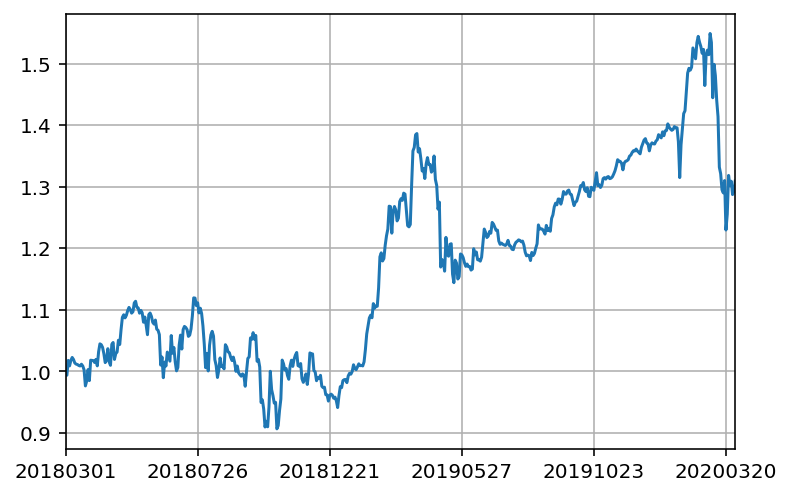

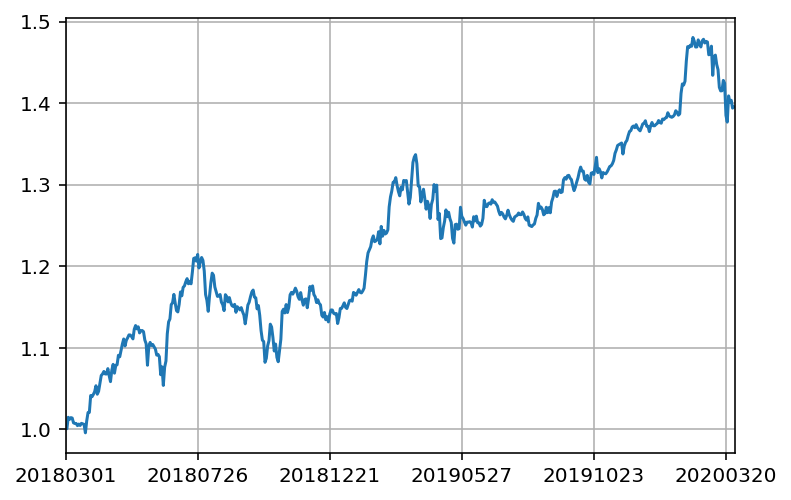

In [365]:
np.cumprod(1+df_ret["ret_2"]).plot()
plt.grid()
plt.show()
index_hq["hs300_ret"] =(index_hq["S_DQ_CLOSE"].shift(-1) - index_hq["S_DQ_CLOSE"])/index_hq["S_DQ_CLOSE"]
np.cumprod(1+df_ret["ret_2"]-index_hq["hs300_ret"]*df_stk_ls["position_pool_2"]).plot()
plt.grid()
plt.show()

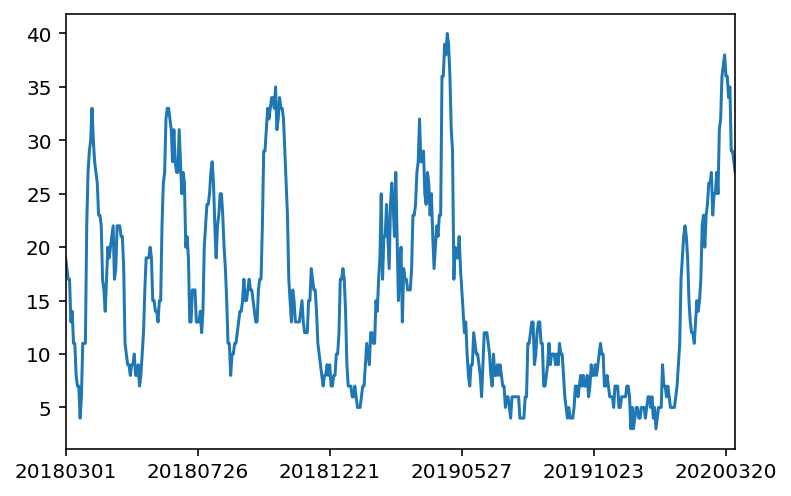

In [370]:
df_stk_ls["stk_num_2"].plot()

In [306]:
series = df_ret.loc["20190801":"20200331",["stk_pool_1","stk_pool_2"]].apply(lambda x:[len(set(x[0])-set(x[1])),
                                                                                       len(set(x[0])&set(x[1])),
                                                                                      len(x[0]),len(x[1])],axis=1)
series.apply(pd.Series)[0].mean()

1.5031055900621118

In [244]:
turnover_ls = []
for date in get_trade_dates("20180302","20200330"):
    stk_pool_td = df_ret["stk_ls_cum_filtered"].loc[date]
    stk_pool_yd = df_ret["stk_ls_cum_filtered"].loc[get_previous_trade_date(date)]
    
    common_stk = set(stk_pool_td)& set(stk_pool_yd)
    stk_sell_ratio = (len(stk_pool_yd) - len(common_stk) ) *0.05
    stk_buy_ratio = (len(stk_pool_td) - len(common_stk) ) *0.05
    
    
    turnover_ls.append(stk_buy_ratio+stk_sell_ratio)
sum(turnover_ls)/len(turnover_ls)

0.0664031620553362

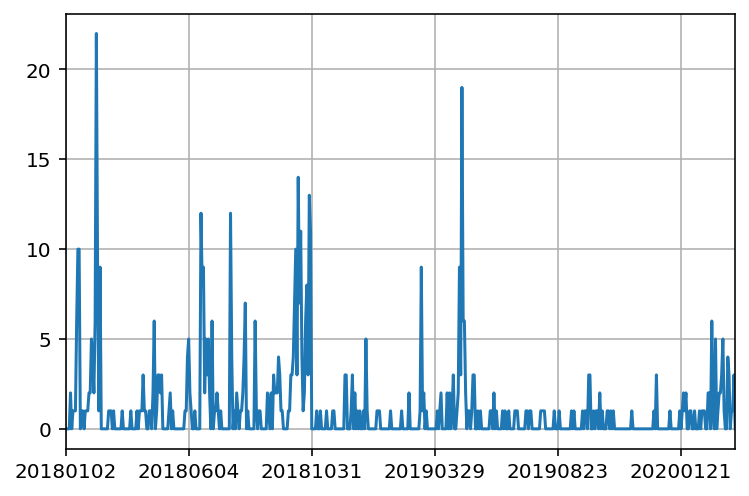

In [247]:
df_ret["stk_num"].plot()
plt.grid()

In [248]:
df_ret

,ret,stk_num,stk_ls,stk_ls_cum,stk_ls_cum_filtered,stk_silent_1,stk_silent_2
20180102,NaN,0,[],NaN,NaN,NaN,NaN
20180103,NaN,0,[],NaN,NaN,NaN,NaN
20180104,NaN,0,[],NaN,NaN,NaN,NaN
20180105,NaN,0,[],NaN,NaN,NaN,NaN
20180108,0.011033,2,"[601336.SH, 002294.SZ]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
20200325,NaN,0,[],"[002050.SZ, 603986.SH, 002945.SZ, 000596.SZ, 6...","[002050.SZ, 603986.SH, 002945.SZ, 000596.SZ, 6...","[600688.SH, 002624.SZ]","[000661.SZ, 600276.SH, 603288.SH]"
20200326,0.046034,1,[600438.SH],"[600438.SH, 002050.SZ, 603986.SH, 002945.SZ, 0...","[600438.SH, 002050.SZ, 603986.SH, 002945.SZ, 0...","[600688.SH, 002624.SZ]","[000661.SZ, 600276.SH, 603288.SH]"
20200327,-0.084037,1,[002065.SZ],"[002065.SZ, 600438.SH, 002050.SZ, 603986.SH, 0...","[002065.SZ, 600438.SH, 002050.SZ, 603986.SH, 0...","[600688.SH, 002624.SZ]","[000661.SZ, 600276.SH, 603288.SH]"
20200330,0.022635,3,"[002065.SZ, 002555.SZ, 600703.SH]","[002065.SZ, 002555.SZ, 600703.SH, 600438.SH, 0...","[002065.SZ, 002555.SZ, 600703.SH, 600438.SH, 0...","[600688.SH, 002624.SZ]","[000661.SZ, 600276.SH, 603288.SH]"
